## Preparing the dataset
<p>Streaming services with large music catalogs have become the main way for many people to listen to their favorite tunes. However, the huge amount of music available can make it difficult for users to find new music that matches their preferences.</p>
<p>To help with this, streaming services have begun using methods to categorize music and provide personalized recommendations. One method involves analyzing the raw audio data of a song and scoring it based on various metrics. In this project, we will use data compiled by a research group called The Echo Nest to classify songs as either "Hip-Hop" or "Rock" without listening to any of the songs ourselves. To do this, we will clean the data, do some exploratory data visualization, and use feature reduction to feed the data into simple machine learning algorithms like decision trees and logistic regression.</p>
<p>We will start by creating two pandas DataFrames from two different files that contain metadata and track metrics for the songs: one file is in CSV format and the other is in JSON format. These DataFrames will be merged to create features and labels (also known as "X" and "y") for classification later on.</p>

In [21]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv("datasets/fma-rock-vs-hiphop.csv")

# Read in track metrics with features
echonest_metrics = pd.read_json("datasets/echonest-metrics.json")

# Merge relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(tracks[['track_id', 'genre_top']], on='track_id')

# Check information of resultant dataframe
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


In [22]:
display(tracks.head())
display(echonest_metrics.head())
echo_tracks.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
2,151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],...,NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
3,152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],...,NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
4,153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],...,NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood


,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


## Creating correlation matrix
<p>It's important to avoid using variables that are highly correlated with each other in our data, as this can lead to feature redundancy. This can have several negative consequences, such as making our model more complex and harder to interpret, increasing the risk of overfitting, and slowing down computation time when working with large datasets.</p> 

<p>To identify any strongly correlated features in our data, we can use the built-in functions in the <code>pandas</code> package.</p>

In [23]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


## Splitting the data
<p>In order to improve the performance of our model, we want to use as few features as possible while still achieving good results. We previously analyzed the correlations between the features and did not find any particularly strong ones. Now we can split our data into two arrays: one containing the features and another containing the labels (the genre of the track).</p>
<p>Before building the model, we will perform some preprocessing steps to optimize the data for modeling. These steps will help improve the accuracy and efficiency of our model.</p>

In [24]:
# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split

# Create features
features = echo_tracks.drop(["genre_top", "track_id"], axis=1).values

# Create labels
labels = echo_tracks["genre_top"].values

# Split our data, we keep test_size = 0.25 (as it is by default)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)


In [25]:
display(train_features[:3, :3])
test_features[:3, :3]

array([[9.48677459e-01, 1.37199242e-01, 2.47403596e-02],
       [1.02727000e-05, 1.18115308e-01, 7.50281301e-01],
       [3.12262570e-02, 6.28698289e-01, 8.31143855e-01]])

array([[0.70243534, 0.4144095 , 0.2179091 ],
       [0.18201668, 0.5798426 , 0.32738372],
       [0.84948   , 0.60548623, 0.31545322]])

## Scaling the features
<p>To simplify our model and use as few features as possible while still achieving good results, we can apply a technique called <strong>principal component analysis (PCA)</strong>.</p>
<p>PCA works by rotating the data along the axis of highest variance, which allows us to determine the relative contribution of each feature to the variance between classes. However, it's important to note that PCA uses the absolute variance of a feature to rotate the data, so a feature with a broader range of values may overpower and bias the algorithm relative to the other features.</p>

<p>To prevent this, we will normalize our train and test features using a method called <em>standardization</em>. This involves transforming the data so that all features have a mean of 0 and a standard deviation of 1 (resulting in a z-score).</p>


In [26]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Create StandardScaler object
scaler = StandardScaler()

# Scale train_features and test_features
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

In [27]:
display(scaled_train_features[:3, :3])
display(scaled_test_features[:, 2].mean())
display(scaled_test_features[:, 2].std())
scaled_test_features[:3, :3]

array([[ 1.24994743, -1.64927931, -2.45820448],
       [-1.33744998, -1.75457157,  0.5134387 ],
       [-1.25231142,  1.06248053,  0.8446325 ]])

0.0033314763549054556

0.9978729657625621

array([[ 0.57834602, -0.11982028, -1.66703124],
       [-0.84104522,  0.79292784, -1.21864922],
       [ 0.97939601,  0.93441209, -1.26751374]])

## Applying PCA to scaled data
<p>Now that we have preprocessed our data, we can use PCA to determine how much we can reduce the dimensionality of the data. To help us find the optimal number of components to use, we can use two tools: <strong>scree plots</strong> and <strong>cumulative explained ratio plots</strong>.</p>
<p>Scree plots show the number of components on the x-axis and the variance explained by each component on the y-axis, with the components sorted in descending order of variance. These plots can help us understand which components contribute the most to the variance in our data. When interpreting a scree plot, we often look for an "elbow" (a steep drop from one data point to the next) to determine the appropriate cutoff for the number of components to use. </p>

Text(0.5, 0, 'Principal Component #')

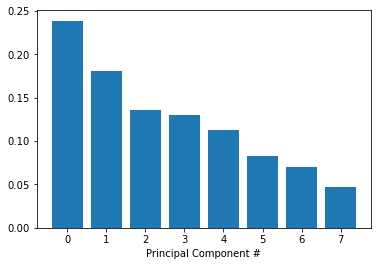

In [28]:
# This allows plots to appear in the notebook
%matplotlib inline

# Import plotting module and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# Plot explained variance using barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

In [29]:
exp_variance

array([0.23895983, 0.18149129, 0.13648392, 0.13004899, 0.1124591 ,
       0.08329047, 0.07040829, 0.04685811])

## Further visualization of PCA
<p>If the scree plot does not show a clear elbow, it may be difficult to determine the optimal number of intrinsic dimensions using this method. However, we can also use a <strong>cumulative explained variance plot</strong> to help us decide on the number of features to use.</p>
<p>This plot shows the cumulative variance explained by the components, and we can choose a cutoff (such as explaining 85% of the variance) to determine the appropriate number of components. </p>
<p>Once we determine that, we can perform PCA with that many components, ideally reducing the dimensionality of our data.</p>

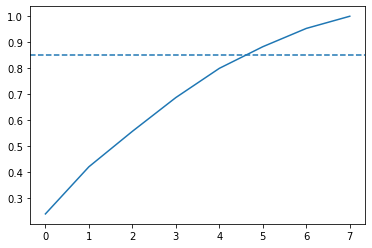

In [30]:
# Import numpy
import numpy as np

# Calculate cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot cumulative explained variance and draw dashed line at 0.85
fig, ax = plt.subplots()
ax.plot(range(pca.n_components_), cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

## Reducing dimensions using PCA
<p>After analyzing the cumulative explained variance plot, we determined that using 6 components can explain approximately 85% of the variance in our data. </p>
<p>Based on this information, we will use 6 components in our PCA analysis to reduce the dimensionality of our train and test features.</p>

In [31]:
# Perform PCA with 6 components
pca = PCA(n_components=6, random_state=10)

# Fit and transform scaled training features using pca
train_pca = pca.fit_transform(scaled_train_features)

# Transform scaled test features using pca
test_pca = pca.transform(scaled_test_features)

## Training a decision tree classifier
<p>Now that we have reduced the dimensionality of our data using PCA, we can use this lower-dimensional projection to classify songs into genres. To do this, we will use a simple and intuitive machine learning algorithm called a <strong>decision tree</strong>.</p>
<p>Decision trees are rule-based classifiers that use a tree structure of binary decisions to classify data points into one of two or more categories.</p>

In [32]:
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# Create DecisionTreeClassifier object
tree = DecisionTreeClassifier(random_state=10)

# Train decision tree
tree.fit(train_pca, train_labels)

# Predict labels for test data
pred_labels_tree = tree.predict(test_pca)

## Comparing decision tree to logistic regression
<p>Although our decision tree is performing well, it's always a good idea to try out other algorithms to see if we can find one that performs even better. One option is <strong>logistic regression</strong>, which uses the logistic function to calculate the odds that a given data point belongs to a particular class. </p>
<p>By comparing the performance of our decision tree and logistic regression models using metrics such as the false positive and false negative rates (which measure the number of inaccurately classified points), we can choose the model that performs best on our data.</p>

In [33]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Create LogisticRegression object
logreg = LogisticRegression(random_state=10)

# Train logistic regression and predict labels for test set
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

# Import classification_report
from sklearn.metrics import classification_report

# Generate classification reports for decision tree and logistic regression models
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

# Print classification reports
print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.63      0.62      0.62       235
        Rock       0.91      0.91      0.91       966

    accuracy                           0.85      1201
   macro avg       0.77      0.77      0.77      1201
weighted avg       0.85      0.85      0.85      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



## Balancing the data for improved performance
<p>Both our decision tree and logistic regression models have an average precision of 85% and 87%. However, examining the classification report shows that the models disproportionately misclassify hip-hop songs as rock songs. </p>
<p>One possible reason for this is the imbalanced number of data points for each class. We have significantly more data points for the rock class than for the hip-hop class, which could be skewing the model's ability to distinguish between the two classes. As a result, most of the model's accuracy is driven by its ability to classify rock songs, rather than a balanced performance across all classes. </p>

In [34]:
# Subset hip-hop and rock tracks
hop_only = echo_tracks[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks[echo_tracks['genre_top'] == 'Rock']

# Sample rock songs to have same number as hip-hop songs
rock_only = rock_only.sample(n=len(hop_only), random_state=10)

# Concatenate hip-hop and rock tracks to create balanced dataset
rock_hop_bal = pd.concat([rock_only, hop_only])

# Create features and labels from balanced dataset
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']

# Split data into train and test sets, and then transform
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)

train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))

## Assessing the impact of balanced data on model bias
<p>We have balanced our dataset by accounting for the imbalanced number of data points for each class. Now, we want to test whether balancing the data improves the model's bias towards the "Rock" classification while still maintaining overall classification performance. </p>

In [35]:
# Train decision tree and logistic regression on balanced data
tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

tree.fit(train_pca, train_labels)
logreg.fit(train_pca, train_labels)

pred_labels_tree = tree.predict(test_pca)
pred_labels_logit = logreg.predict(test_pca)

# Compare models with classification report
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.77      0.79       230
        Rock       0.78      0.82      0.80       225

    accuracy                           0.80       455
   macro avg       0.80      0.80      0.80       455
weighted avg       0.80      0.80      0.80       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.81      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.83      0.82      0.82       455



## Evaluating models using cross-validation
<p>Balancing our data has successfully removed the bias towards the more prevalent class. To more accurately evaluate the performance of our models, we can use a technique called <strong>cross-validation</strong> (CV). </p>
<p>Before we can perform cross-validation, we need to create pipelines to scale our data, apply PCA, and instantiate our chosen models (<code>DecisionTreeClassifier</code> and <code>LogisticRegression</code>). Cross-validation is useful because the way that the data is split into train and test sets can affect model performance. CV attempts to split the data multiple ways and test the model on each split to mitigate this issue. </p>
<p>One common method of cross-validation is <strong>K-fold</strong> CV, which divides the data into K equally sized subsets. The model is then trained and tested on each subset, and the results are aggregated to obtain a final model performance score.</p>

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score

# Create pipelines for Decision Tree and Logistic Regression
tree_pipe = Pipeline([("scaler", StandardScaler()), 
                      ("pca", PCA(n_components=6)), 
                      ("tree", DecisionTreeClassifier(random_state=10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), 
                        ("pca", PCA(n_components=6)), 
                        ("logreg", LogisticRegression(random_state=10))])

# Use KFold cross-validation with 10 splits
kf = KFold(n_splits=10)

# Train models with cross-validation
tree_score = cross_val_score(tree_pipe, features, labels, cv=kf)
logit_score = cross_val_score(logreg_pipe, features, labels, cv=kf)

# Print mean and standard deviation of scores
print("Decision Tree :", round(tree_score.mean(), 2))
print("Logistic Regression:", round(logit_score.mean(), 2))

Decision Tree : 0.76
Logistic Regression: 0.78


## Conclusion
<p>In this project, we analyzed a dataset of songs and their associated genres and developed machine learning models to classify songs into their respective genres. We compared the performance of decision tree and logistic regression models using K-fold cross-validation and found that the <code>logistic regression</code> model had a mean accuracy of <strong>78%</strong>, while the <code>decision tree</code> model had a mean accuracy of <strong>76%</strong>.</p>
<p>Overall, both models performed well on the dataset, but the logistic regression model was slightly more accurate.</p>
